# Dark Matter Only Simulations



In [1]:
import unyt
import astropy.units as u
import scipy
from astropy.cosmology import Planck18 as cosmo

## Parameter files

As well as initial conditions SWIFT also requires a parameter file in `yaml` format. This file tells SWIFT what values it should use for certain internal constants, controls a myriad of physical mechanisms and how they should behave, and tells SWIFT where to find the inputs it needs and where it should put the outputs. You can find example parameter files in the `params` directory which are mostly set up for these simulations. However, we will need to modify some parts of the parameter file for what we have created in the [previous section](Initial_Conditions.ipynb). 

These files are structured in blocks describing various different aspects of SWIFT. You don't need to change much since they have all been set up to work in this repo's structure but do take a look at the different sections and the parameter descriptions. There are a **lot** of moving parts!

### Softening

The main parameter we will have to change is the gravitational softening length since it is a function of the particle resolution. Firstly, I'll give some quick background on what this is. When we run a simulation we are using "mass elements" to represent the true matter distribution. The particles created in the previous step are merely a representation of the mass that makes up the halos, not the true mass elements on the halo. This "quantisation" into elements of the matter field imposes a spatial resolution below which forces are incorrect. To combat this we "soften" the forces by adding a softening length ($\epsilon$) into Newtons law,
$$
F = G\frac{Mm}{r^2 + \epsilon^2}.
$$

This also avoids infinities when particles are in the exact same position. In practice, the equations used to calculate gravity in simulations are much more complicated than the above but the effect of softening is identical. 

The softening length itself is defined as
$$
\epsilon = 0.04\bar{x}
$$
where $\bar{x}$ is the mean inter-particle separation. We can calculate the mean particle separation based on the density of matter in the Universe, the boxsize of the simulation and the particle mass. Recall the values for `boxsize`, `npart1`, and `npart2` from the halo merge you just made and input them below.

In [2]:
# Enter the values you choose from the initial conditions notebook
npart1 = 10000
npart2 = 5000
nbkg = 25 ** 3
boxsize = 2

def soft(boxsize, npart1, npart2, nbkg):
    part_mass = (cosmo.Om(0) * cosmo.critical_density(0) * boxsize ** 3 / (npart1 + npart2 + nbkg)).to(u.Msun)
    xbar = (1 / (cosmo.Om(0) * cosmo.critical_density(0) / part_mass)) ** (1/3)

    s = 0.04 * xbar.to(u.Mpc).value

    return s


# Compute the softening length
comoving_dm_softening = soft(boxsize * u.Mpc, npart1, npart2, nbkg)
print("comoving_DM_softening =", comoving_dm_softening)

comoving_DM_softening = 0.002557003296186042


But we aren't quite done with the softening length yet. The above is the value needed for the `comoving_DM_softening` parameter but we also need the value for `max_physical_DM_softening` this defines the maximum physical softening length. As redshift decreases the softening length will increase in size $\propto (1+z)^{-1}$, hence the necessity of setting a maximal value. We can calculate this maximum by evaluating the physical softening length at some pivot redshift, $z=2.7$ is often used for this pivot. `max_physical_DM_softening` is therefore...

In [3]:
print("max_physical_DM_softening =", comoving_dm_softening / (1 + 2.7))

max_physical_DM_softening = 0.0006910819719421734


Now enter these values into their corresponding entries in `params/DMO_merger.yml` and we are almost ready to go! 

### Simulation duration

We won't run a cosmological simulation to begin with. Note that that means we didn't need both the softening lengths above but it's useful to know. This also means the Cosmology block is unnecessary, the duration of the simulation is instead controlled by the `TimeIntegration` block. You can run with what is already set but depending on how you set up your ICs `time_end` may not be long enough, feel free to extend this if needed.

## Running the simulation

SWIFT is extremely flexible and versatile, you have already seen after configuration the vast number of options we did not turn on in that initial configuration. To enable functionality in SWIFT we need only pass the corresponding configuration flag and runtime arguments when we call the executable. For a dark matter only (DMO) simulation all we need is gravitational calculations, we can therefore use the simple SWIFT executable you created during the set-up phase of the workshop. Recall this required the following configuration flags:
```
./configure --disable-mpi --disable-compiler-warnings --disable-doxygen-doc --disable-hand-vec
```
(here I've included the Mac caveat options but you may not need to). After running this configuration and invoking `make` you will have the SWIFT executable `swift` in the SWIFT directory. Before we finally run the simulation **navigate on the terminal to the base of the SWIFT-Workshop directory**, all of the parameter file paths assume you are running SWIFT at this location.

To run the DMO simulation we now just need to invoke the following on the command line.
```
/path/to/SWIFT/swift --self-gravity --threads <n> params/DMO_merger.yml
```

Here we are using the relative path to the `swift` executable (`/path/to/SWIFT/`) and calling it with `--self-gravity` to enable gravitational calculations between particles, telling SWIFT how many threads to use with `--threads` (choose however many you can throw at it, the more the quicker the simulation will run), and telling it which parameter file to use. If you want a more verbose output to see what SWIFT reports while it's running you can add `-v 1` to enable verbose outputs. For instance, when I ran this simulation I ran the following.
```
../../Codes/SWIFT/swift --self-gravity --threads 12 params/DMO_merger.yml
```

Now that the simulation is running let's return to the [initial conditions](Initial_Conditions.ipynb) and add some baryons! You can come back here when the simulation has finished (or run for a sufficient time) to do the next stage and visualise the simulation.


## Visulising the Simulation

Initially, we'll just make a movie of the simulation. Later on, we'll look at some analysis after running a real set of ICs including cosmology and all the bells and whistles.

The cell below contains the code to make a movie from the simulation. The only part you should need to edit is the number of frames (`nframes`). This should match the number of snapshots in `snapshots/dmo_merger`. If you did not change `time_end` you should not need to edit this cell at all. Run it and you will find an `mp4` file in the `videos` directory and can see what you have made and run. Remember what we have just made is entirely fake!

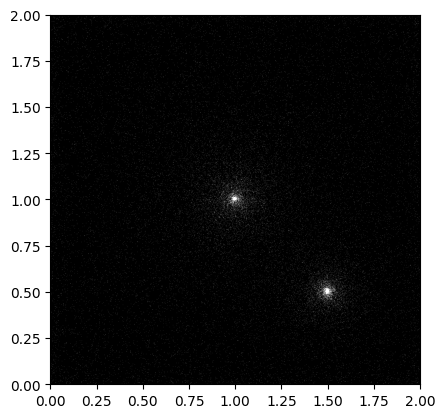

In [7]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

# How many frames will there be? Change this if necessary
nframes = 501

# Set up the plot
fig, ax = plt.subplots()

# Open the first snapshot and extract the DM coordinates
hdf = h5py.File("../snapshots/dmo_merger/snapshot_0000.hdf5", "r")
pos = hdf["PartType1/Coordinates"][:]
hdf.close()
# Make the first frame from the first snapshot at softening resolution
H, _, _ = np.histogram2d(pos[:, 0], pos[:, 1], bins=np.arange(0, boxsize + comoving_dm_softening, comoving_dm_softening))

# Plot the first frame
im = ax.imshow(np.arcsinh(H), cmap="Greys_r", extent=[0, boxsize, 0, boxsize])

def animate(i):
    """
    Make each frame for snapshot i.
    """

    # Open the snapshot and extract DM coordinates
    hdf = h5py.File("../snapshots/dmo_merger/snapshot_%s.hdf5" % str(i).zfill(4), "r")
    pos = hdf["PartType1/Coordinates"][:]
    hdf.close()

    # Make a 2D histogram at softening resolution
    H, _, _ = np.histogram2d(pos[:, 0], pos[:, 1], bins=np.arange(0, boxsize + comoving_dm_softening, comoving_dm_softening))

    # Populate the frame with this 2D histogram
    im.set_array(H)

    return [im]

# Make the animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=nframes)

# Write it to mp4
FFwriter = matplotlib.animation.FFMpegWriter(fps=10)
ani.save('../videos/DMO_merger.mp4', writer =FFwriter)